# Lab 2: Monte Carlo

## Imports

### If you want to check the solution directly, just uncomment the line:
from BJAgent_sol import BJAgent

In [1]:
!pip install matplotlib
!pip install tqdm
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\stoic\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\stoic\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
     --- --------------------------------- 30.7/294.6 kB 660.6 kB/s eta 0:00:01
     --------------- ---------------------- 122.9/294.6 kB 1.4 MB/s eta 0:00:01
     --------------------------------- ---- 256.0/294.6 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 294.6/294.6 kB 1.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\stoic\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline

import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
from tqdm import trange
import seaborn as sns
import pandas as pd
from random import random
import warnings
warnings.filterwarnings("ignore")

#cross check with our solutions once you finish
#from BJAgent_your import BJAgent, MonteCarlo_BJAgent
from BJAgent_sol import BJAgent, MonteCarlo_BJAgent

from utils import *

MODEL_PATH = 'models/'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


## What is Monte Carlo Method in general

You can think of it as a fancy way of saying **trial-and-error for some iterations then find an average**.

In [3]:
# Let's find pi using MC:
# - draw N samples inside a [1,1] box and if they fall inside unit circle we count them as inside.
# The full explanation here: https://academo.org/demos/estimating-pi-monte-carlo/
inside = 0
n = 10**6 # 10^6

x_inside = []
y_inside = []
x_outside = []
y_outside = []

for _ in range(n):
    x = random()
    y = random()
    if x**2+y**2 <= 1:
        inside += 1
        x_inside.append(x)
        y_inside.append(y)
    else:
        x_outside.append(x)
        y_outside.append(y)

pi = 4*inside/n
print(f'Pi according to estimation is {pi}.')

"""
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(x_inside, y_inside, color='g', marker='s')
ax.scatter(x_outside, y_outside, color='r', marker='s')
fig.show()
"""

Pi according to estimation is 3.1413.


"\nfig, ax = plt.subplots()\nax.set_aspect('equal')\nax.scatter(x_inside, y_inside, color='g', marker='s')\nax.scatter(x_outside, y_outside, color='r', marker='s')\nfig.show()\n"

## Colab Setup

## Recap

### What is Reinforcement Learning

Reinforcement learning formulates interaction between an **agent** and its **environment** as **Markov decision processes**. For a given **state**, an agent takes an **action** based on the current **state**. In response to that action at that state, the agent will then get some **reward** from the environment, and that state changes to the next one.

$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 \rightarrow ... \rightarrow S_{t-1} \rightarrow A_{t-1} \rightarrow R_t \rightarrow S_{t}$

![RL Framework](img/rl_framework.png)
Source: [Sutton and Barto](https://cdn.preterhuman.net/texts/science_and_technology/artificial_intelligence/Reinforcement%20Learning%20%20An%20Introduction%20-%20Richard%20S.%20Sutton%20,%20Andrew%20G.%20Barto.pdf)

# This lab: How do we deal with stochastic environment and policy?

There are two main approaches in solving reinforcement learning: **model-based** and **model-free** approaches. 

The model-based approach assumes that we have some or full knowledge of how our environment works (God-mode GridWorld).

**The model-free approach relies on our agent to explore the environment without any prior knowledge.**

<img src="img/monte_carlo.jpg" alt="Monte Carlo Casino" width=75%/>

## [Blackjack-v1](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py)

We are going to play the variant of blackjack problem described in Example 5.1 in [Reinforcement Learning: An Introduction by Sutton and Barto](http://incompleteideas.net/book/the-book-2nd.html). The rules are almost the same as a typical casino poker except for:
* There are only two actions for the player: hit or stay
* Cards are dealt randomly with replacement from a standard 52-card deck

<img src="img/blackjack_scores.PNG" alt="Blackjack Scores" />

In [4]:
#env = gym.make('Blackjack-v1', render_mode="human")
env = gym.make('Blackjack-v1')

**Concept Assignment** Using the reinforcement learning scheme we learned from last class, what would Blackjack-v1 look like?

* Environment: Blackjack table
* Agent: Player
* States: ????
* Actions: ????
* Rewards:  ????
* Episodes: ????

### Observation Space (State Space)

The state is a tuple with three elements:
* The player's current score (0-31)
* The dealer's showing card (1-11)
* 1 if the player has a usable ace; 0 if the player does not.

In [5]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [6]:
env.reset()

((14, 2, False), {})

### Action Space

* 0 - stick
* 1 - hit

In [7]:
env.action_space

Discrete(2)

### Reward

* +1 for winning
* +0 for tie
* -1 for losing
* +1.5 for winning with a natural Blackjack (21 starting hand)

In [8]:
print(f'State: {env.reset()}')
print(f'Result: {env.step(0)} Dealer has {sum(env.dealer)}') #next state, reward, done, info

# Note: ech time when the  user sticks, the game ends. 0 action = stick (see above)

State: ((17, 10, False), {})
Result: ((17, 10, False), 0.0, True, False, {}) Dealer has 17


### Human Play

Play a couple of rounds with your own natural neural networks to get a hang of the environment.

In [12]:

state = env.reset()
print(f'Starting hands: You have {state[0]}. Dealer is showing {state[1]}')
done = False
while not done:
    action = int(input('Choose action: '))
    state, reward, done, info, _ = env.step(action)
    print(f'After taking action {action}, You have {state[0]}. Usable ace: {state[2]}')
    if done:
        print(f'You have {state[0]}, Dealer has {sum(env.dealer)}, Reward: {reward}')


Starting hands: You have (14, 3, False). Dealer is showing {}
After taking action 0, You have 14. Usable ace: False
You have 14, Dealer has 17, Reward: -1.0


### Computer Play

This function `run_single_episode`  simulates an agent playing at random 

In [13]:
def run_single_episode(agent):
    result = []
    state = env.reset()
    while True:
        action = agent.getAction(state)
        next_state, reward, done, info, _ = env.step(action)
        result.append((state, action, reward, next_state, done))
        if done:
            break
        state = next_state
    return(result, sum(env.dealer)) #must return a list of tuples (state,action,reward,next_state,done)

randomAgent = BJAgent(env)
res = run_single_episode(randomAgent)
for elem in res[0]:
    print(elem)
    print()
print("Dealer sum: " + str(res[1]))



(((17, 5, False), {}), 0, -1.0, (17, 5, False), True)

Dealer sum: 18


## Optimal Strategy for Blackjack

Black Jack is the game with one of the best odds in the casino. [Ed Thorp (1966)](http://www.eecs.harvard.edu/cs286r/courses/fall12/papers/Thorpe_KellyCriterion2007.pdf) has derived the basic optimal strategy of playing the game using the [Kelly Criterion](http://www.herrold.com/brokerage/kelly.pdf) as the following figure. Those interested in the derivation should check out Thorp's book [Beat the Dealer](https://www.amazon.com/Beat-Dealer-Winning-Strategy-Twenty-One/dp/0394703103) as well as [Bringing Down The House](https://www.amazon.com/gp/product/0743249992/) by Ben Mezrich and its movie adaptation [21](https://www.imdb.com/title/tt0478087/). But for today, we will have nothing to do with the math and everything to do with reinforcement learning, Monte Carlo method.

<img src="img/ed_thorp.PNG" alt="Basic Optimal Strategy for Black Jack" />

In [14]:
# This functions runs an episode with a given policy.
# The policy  is a dictionaryy mapping from state -> action
# env.action_space.sample()  returns a random action  - you could use this one above !
def run_single_episode_with_policy(policy=None):
    result = []
    state = env.reset()
    while True:
        action = None
        if len(state) == 1:
            action = policy[state] if policy else env.action_space.sample()
        elif len(state) == 2:
            action = policy[state[0]] if policy else env.action_space.sample()
        elif len(state) == 3:
            action = policy[state] if policy else env.action_space.sample()

        
        next_state,reward,done,info,_ = env.step(action)
        result.append((state,action,reward,next_state,done))
        state = next_state
        if done: break
    return(result) #must return a list of tuples (state,action,reward,next_state,done)

#load saved optimal q dictionary, i.e. it maps state - > [Q(state, stick), Q(state, hit)]
optimal_q = pickle.load(open(f'{MODEL_PATH}bj_optimal_q.pkl','rb'))

#convert to optimal policy, i.e. a new dictionary mapping state - > argmax(two Q(state, *) actions)
optimal_policy = {state:np.argmax(value) for state, value in optimal_q.items()}

# Stick only policy
stick_policy = {state: 0 for state,value in optimal_policy.items()}

# Play a big number of episodes and compare the results between the following policies:
# A. stick always
# B. random policy
# C. optimal policy
n_trial = 100000
stick_rewards = []
random_rewards = []
optimal_rewards = []
for i in trange(n_trial): #  trange is from tdqm package to show some visual output with the iteration status
    # Run episode under each policy
    stick_res = run_single_episode_with_policy(stick_policy)
    random_res = run_single_episode_with_policy()
    optimal_res = run_single_episode_with_policy(optimal_policy)
    
    # -1 represents the last component index which gives us the final episode transitioon
    # The reward is on position 2
    stick_rewards.append(stick_res[-1][2])
    random_rewards.append(random_res[-1][2])
    optimal_rewards.append(optimal_res[-1][2])
    

100%|██████████| 100000/100000 [00:38<00:00, 2598.44it/s]


In [15]:
# Let's create a pandasdataframe (similar to a SQL table !)
result = pd.DataFrame({'stick':stick_rewards,'random':random_rewards,'optimal':optimal_rewards})
print(result[0:10]) # print the first 10 episode reward results as a demo


   stick  random  optimal
0    1.0     1.0      1.0
1   -1.0    -1.0      1.0
2    1.0    -1.0      1.0
3   -1.0     1.0      1.0
4    1.0     1.0      1.0
5    1.0    -1.0     -1.0
6   -1.0    -1.0     -1.0
7   -1.0    -1.0      1.0
8   -1.0     1.0     -1.0
9    1.0    -1.0      1.0


In [16]:
# Let's plot some stats about the database
print(result.describe())

               stick        random       optimal
count  100000.000000  100000.00000  100000.00000
mean       -0.175700      -0.39371      -0.04119
std         0.959207       0.89670       0.95480
min        -1.000000      -1.00000      -1.00000
25%        -1.000000      -1.00000      -1.00000
50%        -1.000000      -1.00000       0.00000
75%         1.000000       1.00000       1.00000
max         1.000000       1.00000       1.00000


In [17]:
# Now let's make it more visible - put all variables in a column and the values in another one
result_m = result.melt()
print(result_m[0:10])

  variable  value
0    stick    1.0
1    stick   -1.0
2    stick    1.0
3    stick   -1.0
4    stick    1.0
5    stick    1.0
6    stick   -1.0
7    stick   -1.0
8    stick   -1.0
9    stick    1.0


<Axes: xlabel='variable', ylabel='value'>

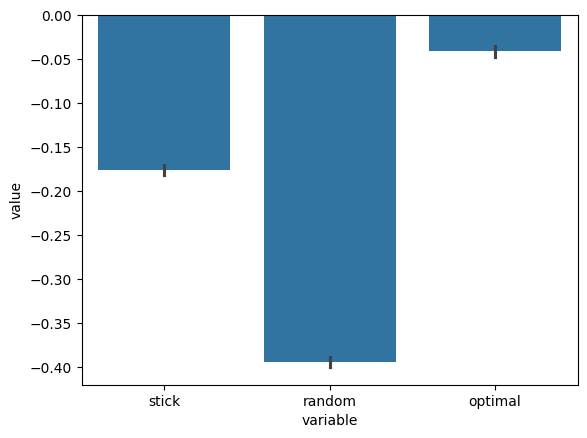

In [18]:
# Using the melted dataset above, draw a barplot to compare visually between them
sns.barplot(data=result_m, x ='variable', y ='value')

## Implement on your own - Control Problem: Greedy within The Limit of Exploration (GLIE)

Remember the first version of MC Control from the book (chapter 5.4)

## Version 1 studied:

Remember the pseudocode for GLIE MC Control:

![First version from chapter 5.4](img/mc1.PNG)

Remember from course that we have a possibility to compute the sum incrementally:
![Incrementa sum](img/mc2.PNG)


Than we move to the GLIE method which performs the best and updates an e-policy

![Greedy within The Limit of Exploration](img/mc_control_glie.PNG)

**Coding Assigment 1** Implement GLIE Monte Carlo control in file BJAgent.py `mc_control_glie`, then run the code below to create the agent in the environment, train the policy

In [ ]:
agent = MonteCarlo_BJAgent(env)
agent.mc_control_glie(n_episode=50000, firstVisit=False)

In [ ]:
# Convert from Q(s,a) to V(s) using the already implemented function, just run the things below to see the graphics output
# Nothing else to implement
agent.q_to_v()
plot_blackjack_values(agent.v)

In [ ]:
plot_policy(agent.policy)

## Watch the trained agent play the game

In [ ]:
numEpisodes = 10

agent = MonteCarlo_BJAgent(env)
for epIndex in range(numEpisodes):
    print(f"***** Episode {epIndex} ******")
    transitions = run_single_episode(agent)
    for elem in transitions[0]:
        print(elem)
    print(transitions[1])

## Challenges

* Use MC to solve the other environments as well:
    * FrozenLake-v1
    * Taxi-v2
    * Any other environments with discrete states and actions at [OpenAI Gym](https://github.com/openai/gym/wiki/Table-of-environments)